In [1]:
# Should equal to 3.9.12 if running from provided docker container
import sys
print(sys.version)

3.9.12 (main, Mar 24 2022, 16:21:12) 
[GCC 7.5.0]


In [2]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [3]:
# Import the dataset
ds = xr.open_dataset("../dataset/gbr1_simple_2022-03-11.nc", chunks={"time": 1})
ds

<xarray.Dataset>
Dimensions:      (k: 44, j: 2389, i: 510, time: 24)
Coordinates:
    zc           (k) float64 dask.array<chunksize=(44,), meta=np.ndarray>
    longitude    (j, i) float64 dask.array<chunksize=(2389, 510), meta=np.ndarray>
    latitude     (j, i) float64 dask.array<chunksize=(2389, 510), meta=np.ndarray>
  * time         (time) datetime64[ns] 2022-03-10T14:00:00 ... 2022-03-11T12:...
Dimensions without coordinates: k, j, i
Data variables: (12/16)
    botz         (j, i) float64 dask.array<chunksize=(2389, 510), meta=np.ndarray>
    eta          (time, j, i) float32 dask.array<chunksize=(1, 2389, 510), meta=np.ndarray>
    u            (time, k, j, i) float32 dask.array<chunksize=(1, 44, 2389, 510), meta=np.ndarray>
    v            (time, k, j, i) float32 dask.array<chunksize=(1, 44, 2389, 510), meta=np.ndarray>
    w            (time, k, j, i) float32 dask.array<chunksize=(1, 44, 2389, 510), meta=np.ndarray>
    salt         (time, k, j, i) float32 dask.array<chunksize=(1, 44, 2389, 510), meta=np.ndarray>
    ...           ...
    RT_expose    (time, k, j, i) float32 dask.array<chunksize=(1, 44, 2389, 510), meta=np.ndarray>
    dhw0         (time, k, j, i) float32 dask.array<chunksize=(1, 44, 2389, 510), meta=np.ndarray>
    dhw1         (time, k, j, i) float32 dask.array<chunksize=(1, 44, 2389, 510), meta=np.ndarray>
    dhw2         (time, k, j, i) float32 dask.array<chunksize=(1, 44, 2389, 510), meta=np.ndarray>
    dhw3         (time, k, j, i) float32 dask.array<chunksize=(1, 44, 2389, 510), meta=np.ndarray>
    swr          (time, j, i) float32 dask.array<chunksize=(1, 2389, 510), meta=np.ndarray>
Attributes:
    title:                    GBR1 Hydro
    description:              eReefs GBR 1k grid with rivers. Uses JCU bathy ...
    paramhead:                GBR 1km resolution grid
    paramfile:                ./prm/gbr1_hydro_nrt.prm
    ems_version:              v1.4.0 rev(6949)
    date_created:             Wed Mar 16 20:42:28 2022
    Conventions:              CF-1.0
    Run_ID:                   2.1
    Run_code:                 GBR1 Hydro|G0.00|H2.10|S0.00|B0.00
    Parameter_File_Revision:  $Revision$
    hasVocab:                 1
    metadata_link:            http://marlin.csiro.au/geonetwork/srv/eng/searc...

In [4]:
# Set depth and time
d = -1 # 1.5m
t = 0 # 2022-03-10T14:00:00

In [5]:
# Center projection to middle lat and long
max_longitude = max(ds.temp.longitude.values[0])
min_longitude = min(ds.temp.longitude.values[-1])
c_longitude = np.median([max_longitude, min_longitude])

max_latitude = max(ds.temp.latitude.values[0])
min_latitude = min(ds.temp.latitude.values[-1])
c_latitude = np.median([max_latitude, min_latitude])

In [6]:
# Extract lat long and current information 
# Little bit hacky but setting nan values to zero prevent the streamplot function from returning NaN error
# Dropping nan could also be done but I couldn't find a method that would maintain the arrays structure,
# as the length of x (ln) and y (lt) must match the size of u and v
ln = np.nan_to_num(ds.isel(k=d, time=t)["longitude"].values, nan=0)
lt = np.nan_to_num(ds.isel(k=d, time=t)["latitude"].values, nan=0)
u = np.nan_to_num(ds.isel(k=d, time=t)["u"].values, nan=0)
v = np.nan_to_num(ds.isel(k=d, time=t)["v"].values, nan=0)

# Combine each array into a single array to add to streamplot
args = [ln, lt, u, v]

/root/gbr_venv/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


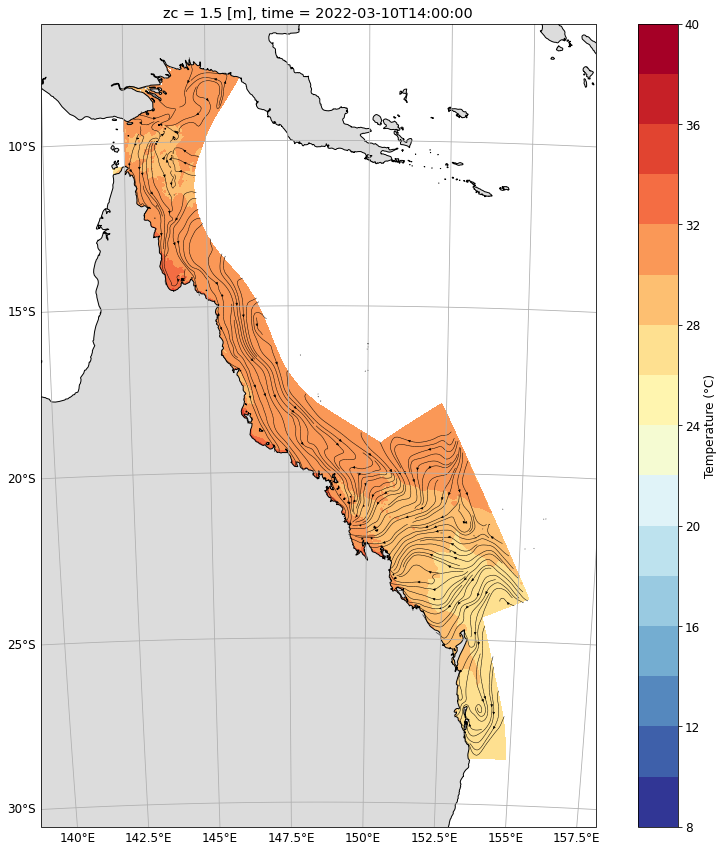

In [7]:
# New figure
fig = plt.figure(figsize=(12, 12))

# Set font size
plt.rc('font', size=12) 

# New plot with central lat and long
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=c_longitude, 
                                               central_latitude=c_latitude))

# Set the extent of the plot
buf = 2 # Degrees
ax.set_extent([min_longitude - buf, max_longitude + buf, 
               min_latitude + buf, max_latitude - buf],
               crs=ccrs.PlateCarree())

# Add current overlay using args from above, density and maxlength
# might need to be adjusted with different layers
# This method just uses matplotlib rather than xarray wrapper as the xarray streamplot function has a
# error in it: <https://github.com/pydata/xarray/blob/main/xarray/plot/dataset_plot.py> line 590
# "xdim" is sometimes undefined as its never initalised if len(ds[x].dims) != 1
sp = ax.streamplot(*args, color='k', arrowsize=0.5, linewidth=0.5, density=8, maxlength=8,
                   transform=ccrs.PlateCarree())

# Add contour plot of temperature at a specific depth and time
# This method uses the matplotlib wrapped xarray contourf function
ds.temp.isel(k=d, time=t).plot.contourf(x="longitude", y="latitude", cmap="RdYlBu_r", 
                                         levels=20, cbar_kwargs={"label": u"Temperature (\N{DEGREE SIGN}C)"},
                                        transform=ccrs.PlateCarree())

# Add grid lines 
grid_lines = ax.gridlines(draw_labels=True)
grid_lines.xformatter = LONGITUDE_FORMATTER
grid_lines.yformatter = LATITUDE_FORMATTER
grid_lines.right_labels = False
grid_lines.top_labels = False 

# Add land features (50m scale looks ok)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', 
                                               scale="10m", 
                                               edgecolor='k', 
                                               facecolor=cfeature.COLORS['land']), 
                                               facecolor='gainsboro')

# Save the figure
plt.tight_layout()
# plt.savefig("../figures/sst_current_gbr.png", facecolor='white', dpi=300)